#### CLEANING PROCESS

In [7]:
#importing libraries
import numpy as np 
import pandas as pd 

import re, nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
import folium
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import missingno as misno

from subprocess import check_output


In [8]:
dfmain = pd.read_csv('Hotel_Reviews.csv') #loading data

In [10]:
dfmain.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [12]:
dfmain.shape

(515738, 17)

In [9]:
dfmain.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

### removing duplicates

In [15]:
duplicate_records_dfmain = sum(dfmain.duplicated())
print(duplicate_records_dfmain)
dfmain_new = dfmain.drop_duplicates()
print('#Rows and #columns after removing duplicate records: {}'.format(dfmain_new.shape))

526
#Rows and #columns after removing duplicate records: (515212, 17)


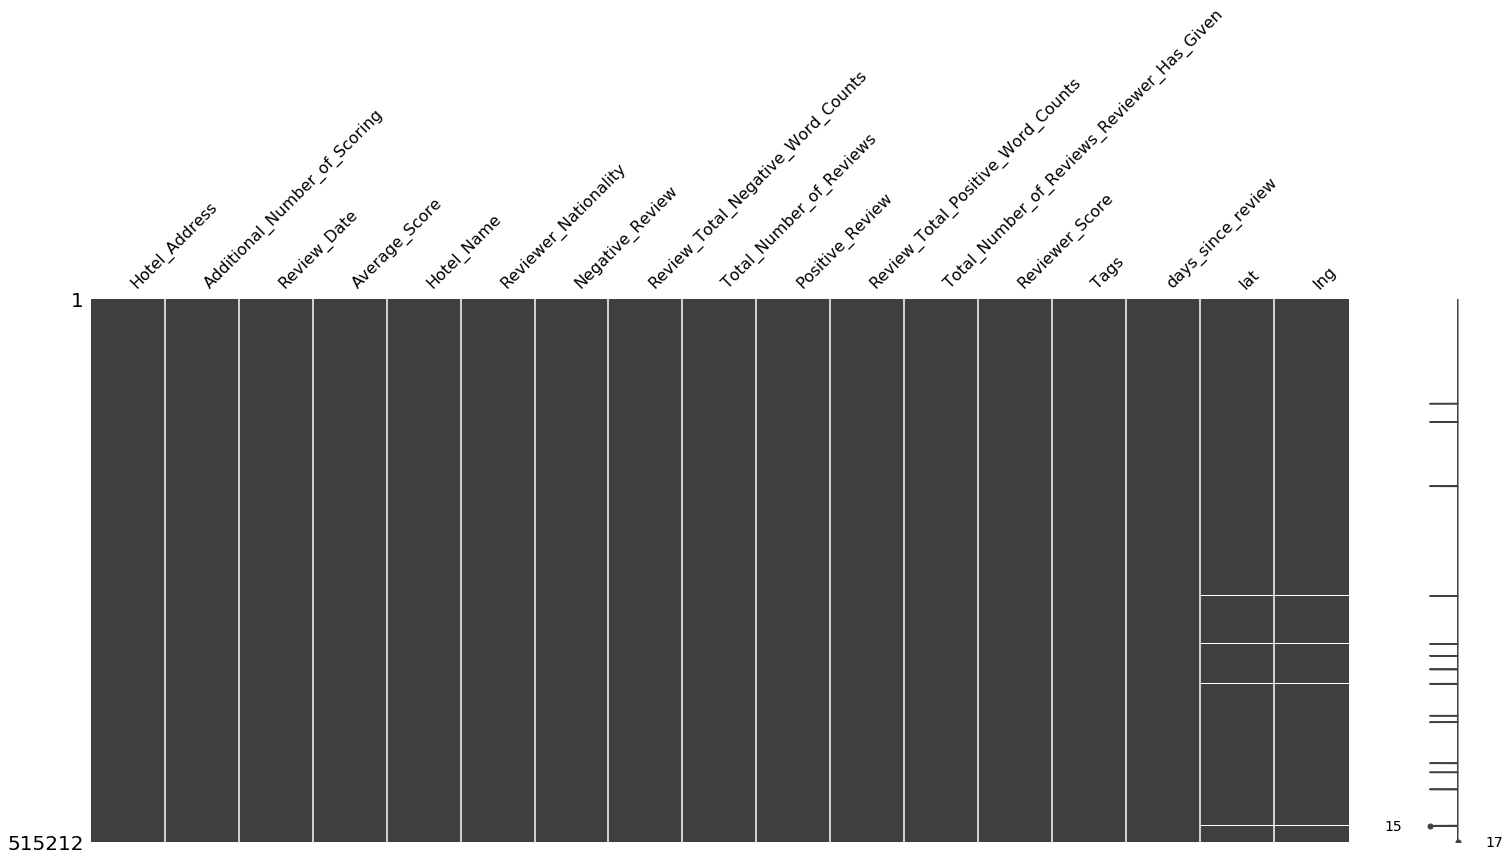

In [16]:
misno.matrix(dfmain_new)

### checking for null values

we will check and remove null values

In [19]:
na_values = lambda dfmain_new: dfmain_new[dfmain_new.isnull().any(axis=1)]
nans_dfmain = na_values(dfmain_new)
nans_dfmain = nans_dfmain[['Hotel_Name','lat','lng']]
print('The number of null values in the dataframe is: {}'.format(len(nans_dfmain)))

The number of null values in the dataframe is: 3268


In [21]:
nans_dfmain.Hotel_Name.describe()

count                                    3268
unique                                     17
top       Fleming s Selection Hotel Wien City
freq                                      658
Name: Hotel_Name, dtype: object

In [22]:
nans_dfmain.Hotel_Name.value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: Hotel_Name, dtype: int64

In [31]:
hotelnames = np.unique(nans_dfmain.Hotel_Name.values)

for hotel in hotelnames:
    print('Number of reviews in the dataset corresponding to the hotel:')
    print(hotel,':{}'.format(len(dfmain_new.loc[dfmain_new.Hotel_Name == hotel])))


Number of reviews in the dataset corresponding to the hotel:
Austria Trend Hotel Schloss Wilhelminenberg Wien :194
Number of reviews in the dataset corresponding to the hotel:
City Hotel Deutschmeister :93
Number of reviews in the dataset corresponding to the hotel:
Cordial Theaterhotel Wien :57
Number of reviews in the dataset corresponding to the hotel:
Derag Livinghotel Kaiser Franz Joseph Vienna :147
Number of reviews in the dataset corresponding to the hotel:
Fleming s Selection Hotel Wien City :658
Number of reviews in the dataset corresponding to the hotel:
Holiday Inn Paris Montmartre :55
Number of reviews in the dataset corresponding to the hotel:
Hotel Advance :28
Number of reviews in the dataset corresponding to the hotel:
Hotel Atlanta :389
Number of reviews in the dataset corresponding to the hotel:
Hotel City Central :563
Number of reviews in the dataset corresponding to the hotel:
Hotel Daniel Vienna :245
Number of reviews in the dataset corresponding to the hotel:
Hotel

In [35]:
dict_lat = {'Fleming s Selection Hotel Wien City':48.209270,
       'Hotel City Central':48.2136,
       'Hotel Atlanta':48.210033,
       'Maison Albar Hotel Paris Op ra Diamond':48.875343,
       'Hotel Daniel Vienna':48.1888,
       'Hotel Pension Baron am Schottentor':48.216701,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':48.2195,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':48.245998,
      'NH Collection Barcelona Podium':41.3916,
      'City Hotel Deutschmeister':48.22088,
      'Hotel Park Villa':48.233577,
      'Cordial Theaterhotel Wien':48.209488,
      'Holiday Inn Paris Montmartre':48.888920,
      'Roomz Vienna':48.186605,
      'Mercure Paris Gare Montparnasse':48.840012,
      'Renaissance Barcelona Hotel':41.392673,
      'Hotel Advance':41.383308}

In [36]:
dict_lng ={'Fleming s Selection Hotel Wien City':16.353479,
       'Hotel City Central':16.3799,
       'Hotel Atlanta':16.363449,
       'Maison Albar Hotel Paris Op ra Diamond':2.323358,
       'Hotel Daniel Vienna':16.3840,
       'Hotel Pension Baron am Schottentor':16.359819,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':16.2856,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':16.341080,
      'NH Collection Barcelona Podium':2.1779,
      'City Hotel Deutschmeister':16.36663,
      'Hotel Park Villa':16.345682,
      'Cordial Theaterhotel Wien':16.351585,
      'Holiday Inn Paris Montmartre':2.333087,
      'Roomz Vienna':16.420643,
      'Mercure Paris Gare Montparnasse':2.323595,
      'Renaissance Barcelona Hotel':2.167494,
      'Hotel Advance':2.162828}

In [37]:
dfmain_new['lat'] = dfmain_new['lat'].fillna(dfmain_new['Hotel_Name'].apply(lambda x: dict_lat.get(x)))
#filling longitude information
dfmain_new['lng'] = dfmain_new['lng'].fillna(dfmain_new['Hotel_Name'].apply(lambda x: dict_lng.get(x)))

C:\Users\vaibh\Anaconda3x\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\vaibh\Anaconda3x\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


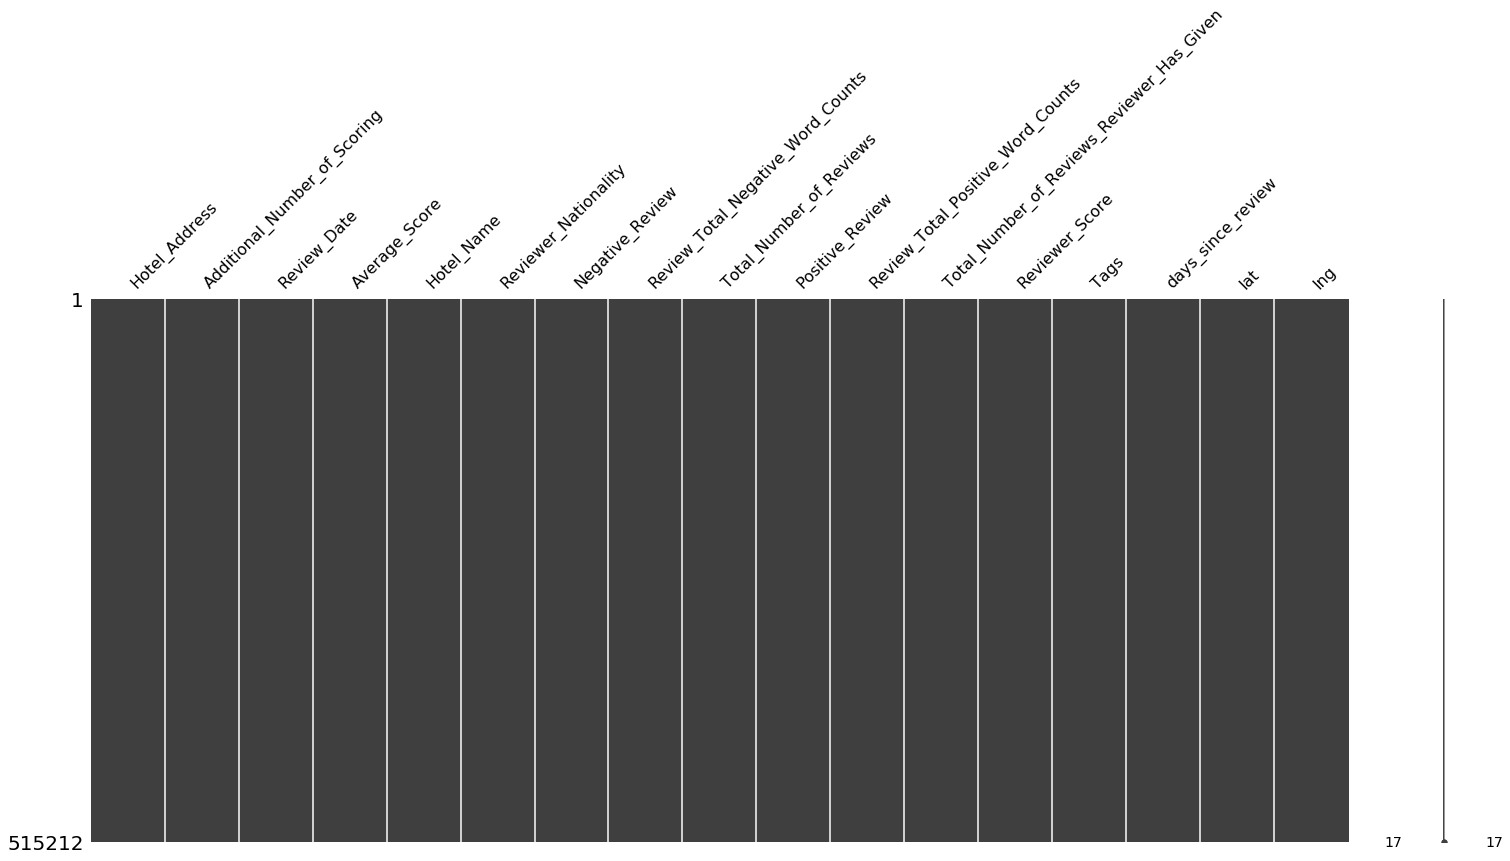

In [38]:
misno.matrix(dfmain_new)

In [40]:
dfmain_new.to_csv('Hotel_Reviews_Nan_Vals_Filled')

In [41]:
dfmain2 = pd.read_csv('Hotel_Reviews_Nan_Vals_Filled')

In [42]:
dfmain2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515212 entries, 0 to 515211
Data columns (total 18 columns):
Unnamed: 0                                    515212 non-null int64
Hotel_Address                                 515212 non-null object
Additional_Number_of_Scoring                  515212 non-null int64
Review_Date                                   515212 non-null object
Average_Score                                 515212 non-null float64
Hotel_Name                                    515212 non-null object
Reviewer_Nationality                          515212 non-null object
Negative_Review                               515212 non-null object
Review_Total_Negative_Word_Counts             515212 non-null int64
Total_Number_of_Reviews                       515212 non-null int64
Positive_Review                               515212 non-null object
Review_Total_Positive_Word_Counts             515212 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515212 non-null int

In [44]:
import matplotlib.pylab as pyl
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 60, 20
rcParams["axes.labelsize"] = 18

import seaborn as sns


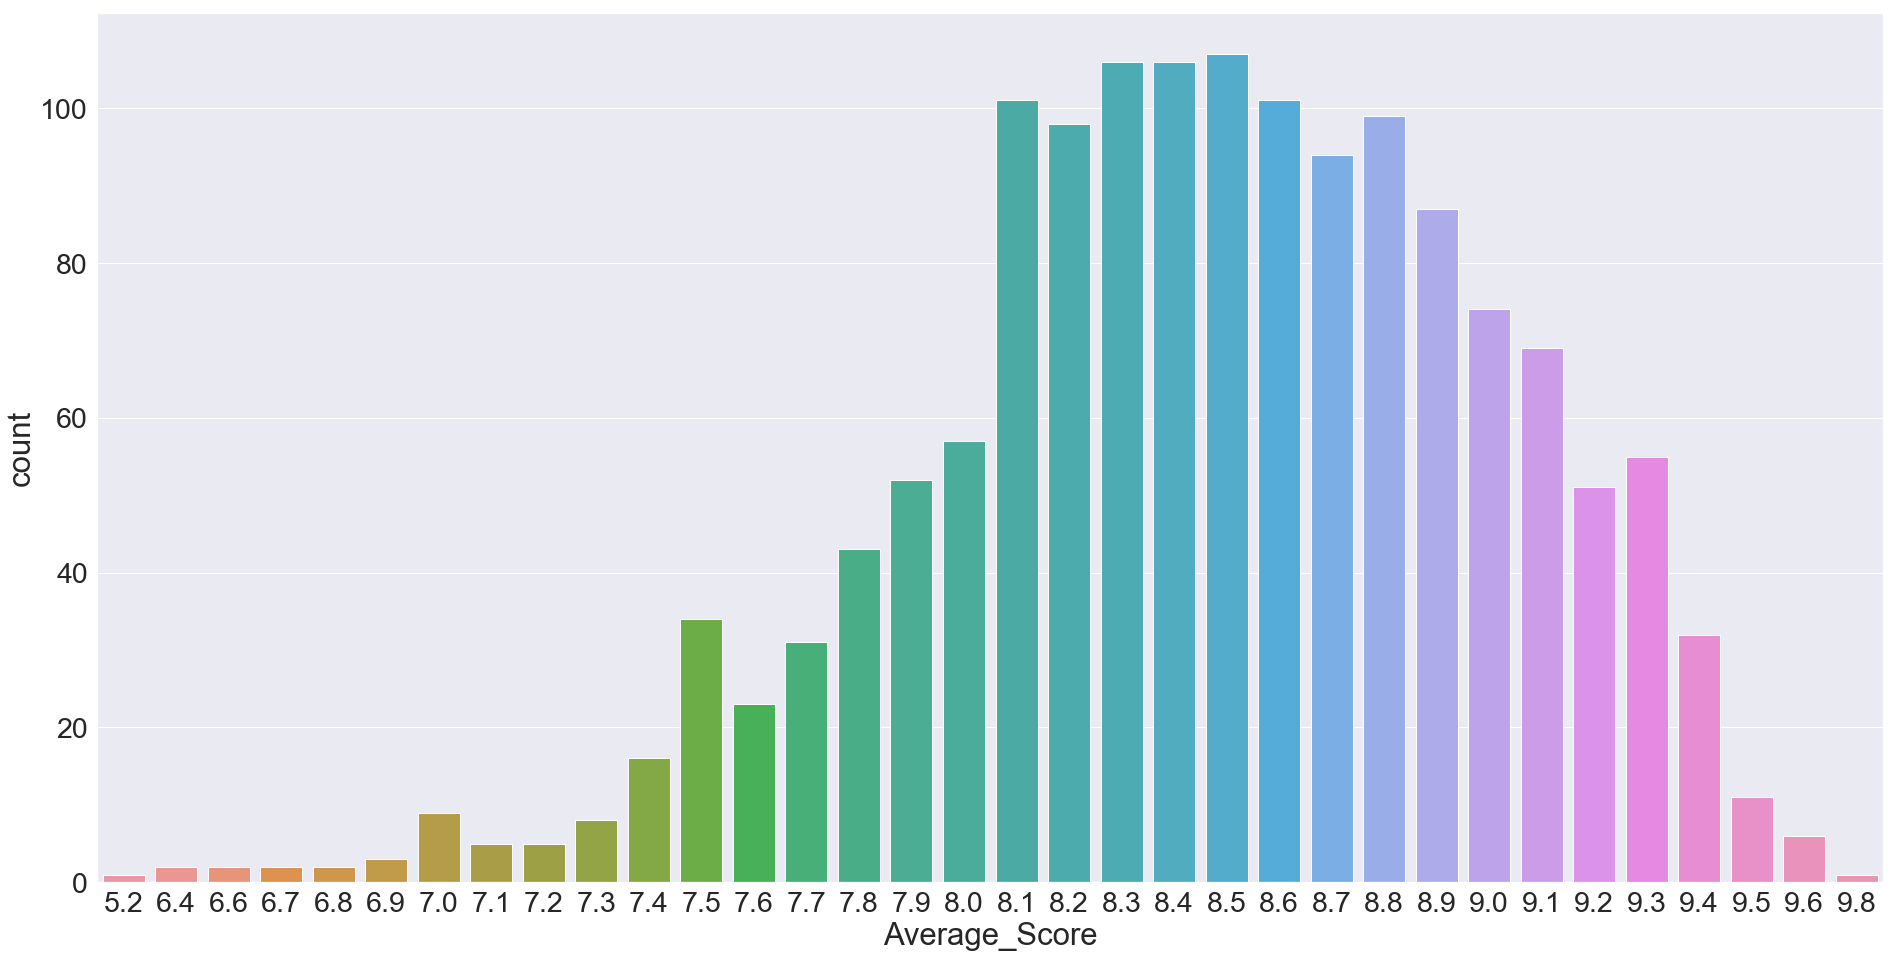

In [46]:
data_plot = dfmain[["Hotel_Name","Average_Score"]].drop_duplicates()
sns.set(font_scale = 2.6)

fig, ax = plt.subplots(figsize=(32,16))
sns.countplot(ax = ax,x = "Average_Score",data=data_plot)

In [43]:
dfmain2.Hotel_Name.describe()


count                                         515212
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: Hotel_Name, dtype: object

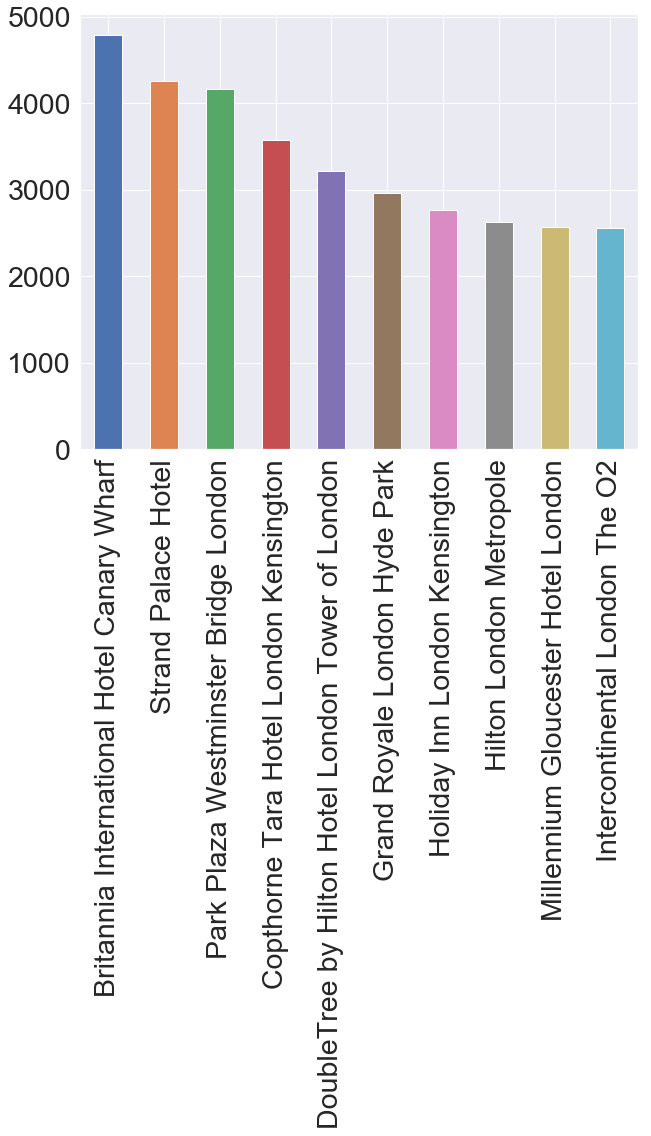

In [48]:
Hotel_Name_count = dfmain2.Hotel_Name.value_counts()
Hotel_Name_count[:10].plot(kind='bar',figsize=(10,8))

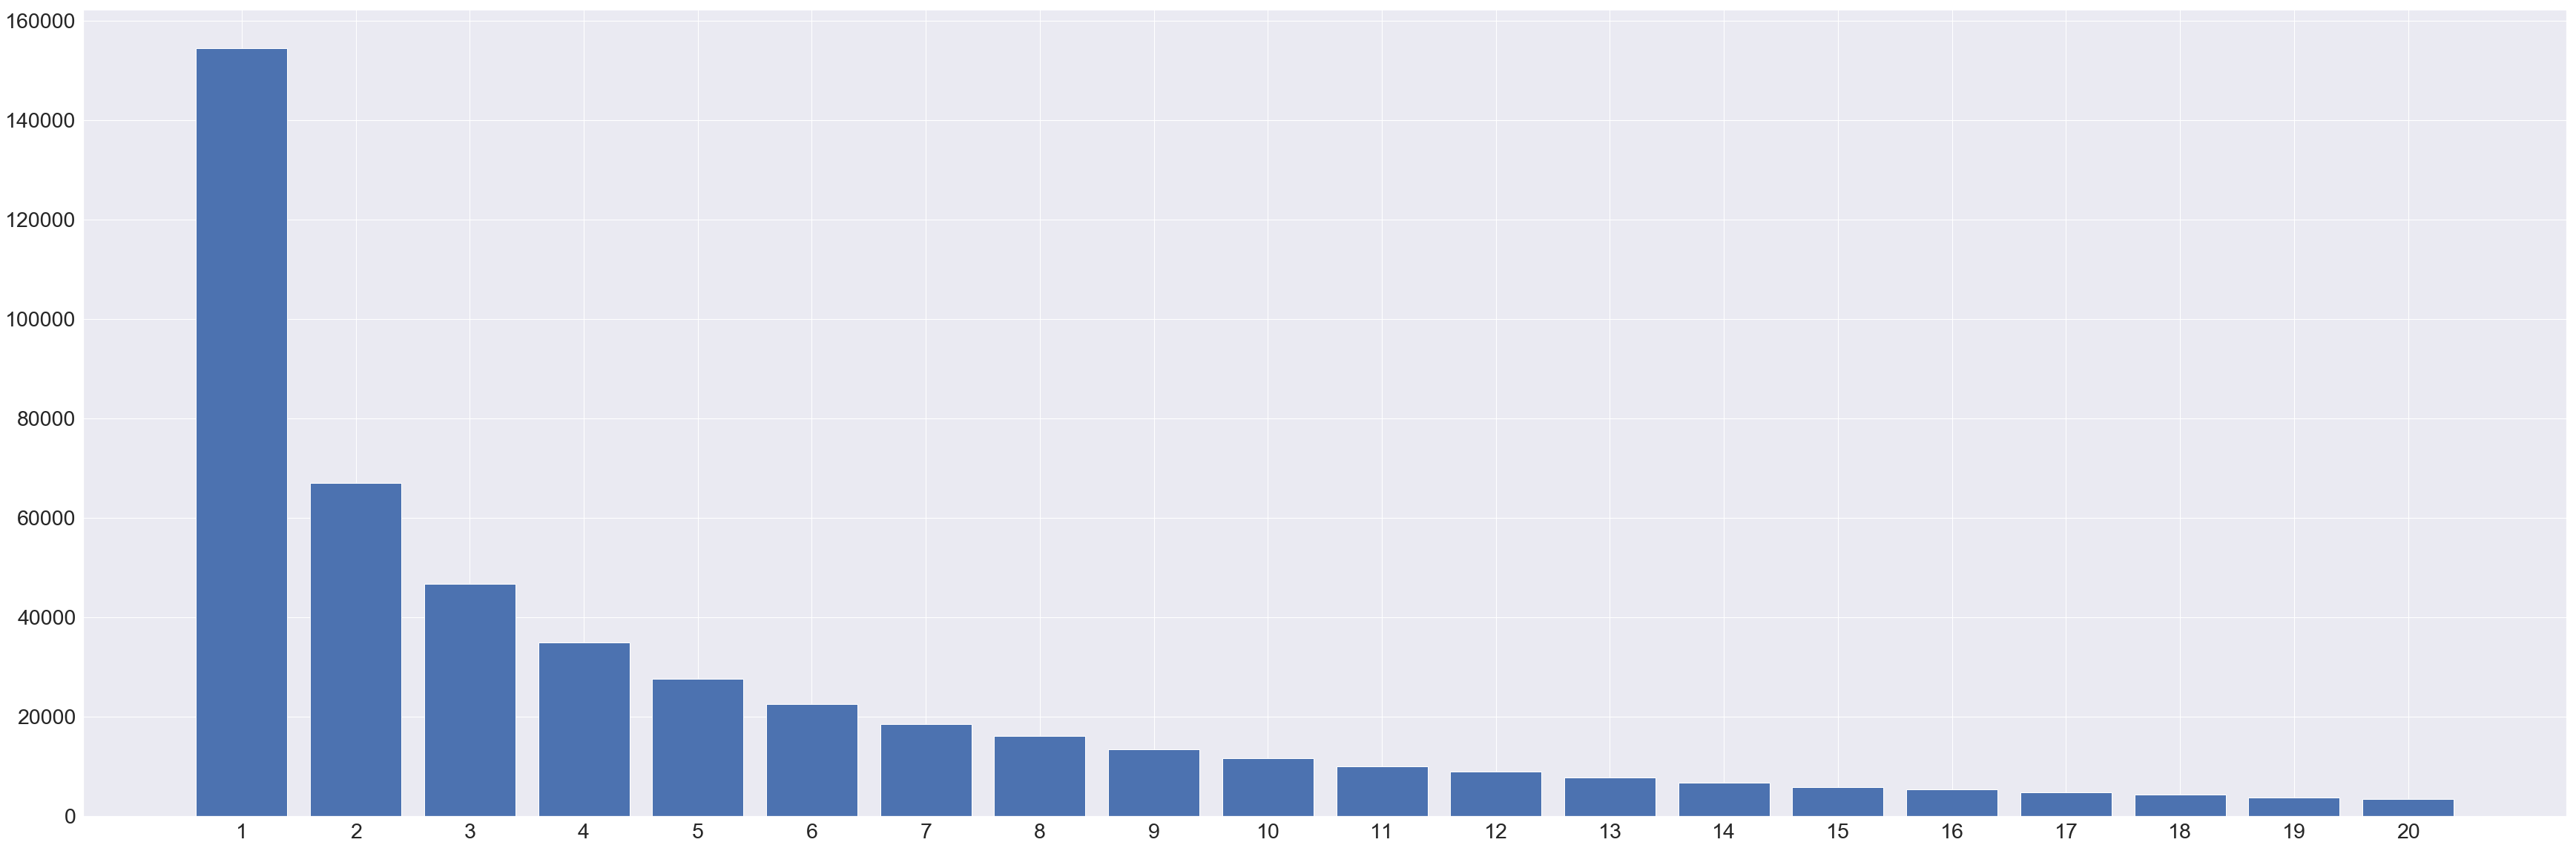

In [61]:
plt.figure()
plt.bar(dfmain2.Total_Number_of_Reviews_Reviewer_Has_Given.value_counts().index[:20],dfmain2.Total_Number_of_Reviews_Reviewer_Has_Given.value_counts().values[:20],tick_label=dfmain2.Total_Number_of_Reviews_Reviewer_Has_Given.value_counts().index[:20])
plt.show()


In [62]:
dfmain2.Total_Number_of_Reviews_Reviewer_Has_Given.value_counts()[:20]

1     154506
2      67011
3      46802
4      34991
5      27604
6      22593
7      18599
8      16126
9      13526
10     11702
11      9980
12      8995
13      7755
14      6752
15      5927
16      5376
17      4860
18      4384
19      3802
20      3427
Name: Total_Number_of_Reviews_Reviewer_Has_Given, dtype: int64

In [71]:
dfmain2.Reviewer_Nationality.describe()

count               515212
unique                 227
top        United Kingdom 
freq                245110
Name: Reviewer_Nationality, dtype: object

In [70]:
text = ""
for i in range(dfmain2.shape[0]):
    text = " ".join([text,dfmain2['Reviewer_Nationality'].values[i]])

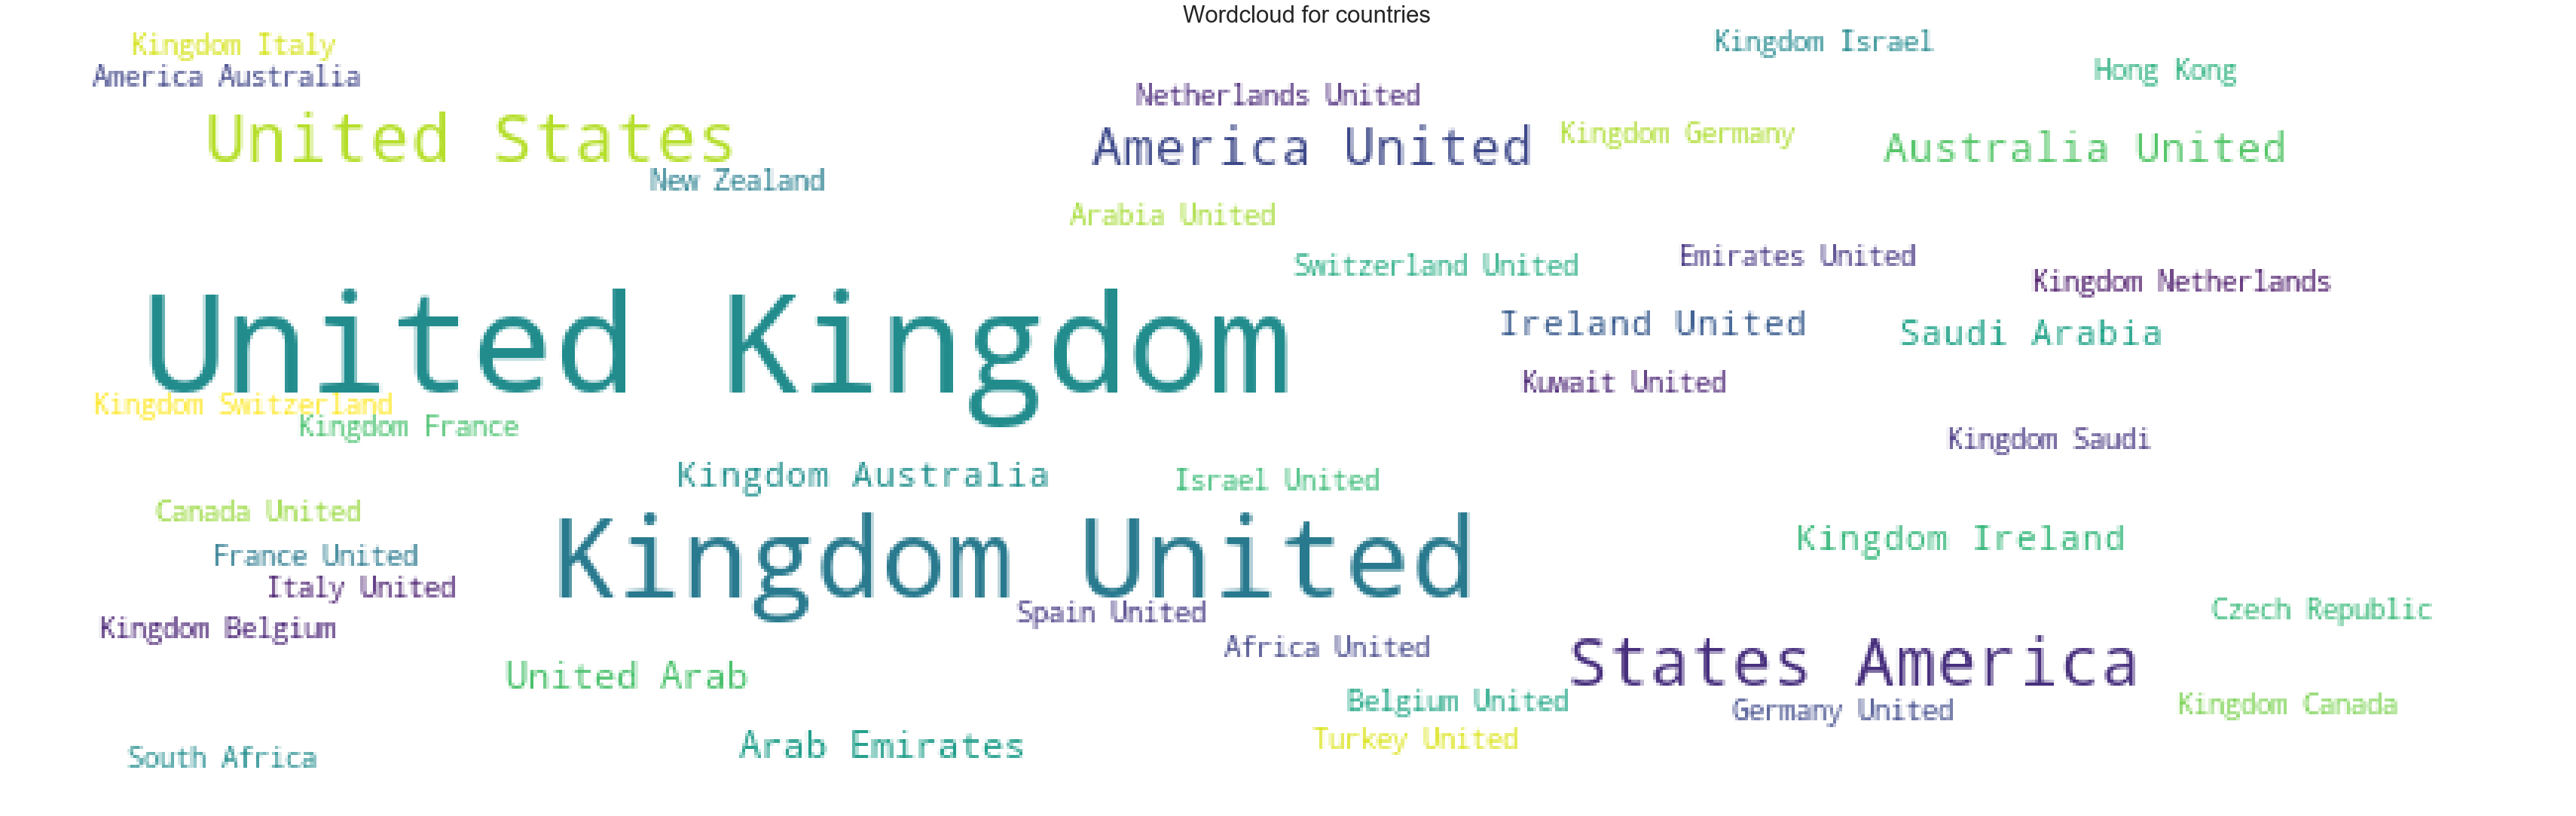

In [74]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width = 800,\
                      height=240, max_font_size=45, max_words=40).generate(text)

plt.imshow(wordcloud)
plt.title("Wordcloud for countries ")
plt.axis("off")
plt.show()

In [75]:
Count_Reviewer_Nat = dfmain2.Reviewer_Nationality.value_counts()
print(Count_Reviewer_Nat[:15])

 United Kingdom               245110
 United States of America      35349
 Australia                     21648
 Ireland                       14814
 United Arab Emirates          10229
 Saudi Arabia                   8940
 Netherlands                    8757
 Switzerland                    8669
 Germany                        7929
 Canada                         7883
 France                         7265
 Israel                         6601
 Italy                          6113
 Belgium                        6024
 Turkey                         5440
Name: Reviewer_Nationality, dtype: int64


In [76]:
#Loading the unique Hotel's information to plot them on the map
temporary_df = dfmain2.drop_duplicates(['Hotel_Name'])
len(temporary_df)

1492

### Plotting the data on a map using folium

In [77]:
map_plot = folium.Map(location=[47, 6], zoom_start=5, tiles = 'Stamen Toner' )

temporary_df.apply(lambda row:folium.Marker(location=[row["lat"], row["lng"]])
                                             .add_to(map_plot), axis=1)

map_plot

In [78]:
positive_words = dfmain2.Review_Total_Positive_Word_Counts.value_counts()
positive_words[:10]

0     35904
6     26887
5     26809
4     24624
7     24517
8     23219
3     22505
9     21188
2     20905
10    19597
Name: Review_Total_Positive_Word_Counts, dtype: int64

In [81]:
a = dfmain2.loc[dfmain2.Review_Total_Positive_Word_Counts == 0]
print('No of completely Negative reviews in the dataset:',len(a))
b = a[['Positive_Review','Negative_Review']]
b[:10]

No of completely Negative reviews in the dataset: 35904


,Positive_Review,Negative_Review
8,No Positive,Even though the pictures show very clean room...
32,No Positive,Our bathroom had an urine order Shower was ve...
98,No Positive,Got charged 50 for a birthday package when it...
121,No Positive,The first room had steep steps to a loft bed ...
134,No Positive,Foyer was a mess Only place to relax was the ...
146,No Positive,We booked a 3 night stay in a suite On arriva...
169,No Positive,Nothing One Of The Receptionist she did a rac...
172,No Positive,Hotel under sonstruction which we weren t awa...
202,No Positive,Renovation around the hotel sometimes can sta...
209,No Positive,Not given the room type we had booked and pre...


In [82]:
neg_words = dfmain2.Review_Total_Negative_Word_Counts.value_counts()
neg_words[:10]

0     127757
2      24631
3      18126
6      17726
5      16788
7      16123
4      15049
8      14709
9      13623
10     12409
Name: Review_Total_Negative_Word_Counts, dtype: int64

In [83]:
a2 = dfmain2.loc[dfmain2.Review_Total_Negative_Word_Counts == 0 ]
print('No of completely positive reviews in the dataset:',len(a2))
b2 = a2[['Positive_Review','Negative_Review']]
b2[:10]

No of completely positive reviews in the dataset: 127757


,Positive_Review,Negative_Review
1,No real complaints the hotel was great great ...,No Negative
13,This hotel is being renovated with great care...,No Negative
15,This hotel is awesome I took it sincirely bec...,No Negative
18,Public areas are lovely and the room was nice...,No Negative
48,The quality of the hotel was brilliant and ev...,No Negative
53,Beautiful setting in a lovely park room very ...,No Negative
55,The hotel is lovely and the staff were amazin...,No Negative
59,Basically everything The style of the hotel i...,No Negative
75,The whole hotel was very clean the staff were...,No Negative
78,Hotel was really nice staff were very friendl...,No Negative


In [84]:
dfmain2['pos_count']=0
dfmain2['neg_count']=0

In [85]:
dfmain2['Negative_Review']=[x.lower().strip() for x in dfmain2['Negative_Review']]
dfmain2['Positive_Review']=[x.lower().strip() for x in dfmain2['Positive_Review']]

In [86]:
dfmain2["neg_count"] = dfmain2.apply(lambda x: 1 if x["Positive_Review"] == 'no positive' or \
                           x['Positive_Review']=='nothing' or \
                           x['Negative_Review']=='everything' \
                           else x['pos_count'],axis = 1)

In [87]:
dfmain2["pos_count"] = dfmain2.apply(lambda x: 1 if x["Negative_Review"] == 'no negative' or \
                           x['Negative_Review']=='nothing' or \
                           x['Positive_Review']=='everything' \
                           else x['pos_count'],axis = 1)

In [88]:
dfmain2.pos_count.value_counts()

0    365231
1    149981
Name: pos_count, dtype: int64

In [89]:
dfmain2.neg_count.value_counts()

0    477358
1     37854
Name: neg_count, dtype: int64

In [95]:
customer_reviews = pd.DataFrame(dfmain2.groupby(["Hotel_Name"])["pos_count","neg_count"].sum())

In [96]:
customer_reviews.head()

,pos_count,neg_count
Hotel_Name,,
11 Cadogan Gardens,55,10
1K Hotel,26,12
25hours Hotel beim MuseumsQuartier,264,30
41,57,0
45 Park Lane Dorchester Collection,19,0


In [97]:
customer_reviews["Hotel_Name"] = customer_reviews.index
customer_reviews.index = range(customer_reviews.shape[0])
customer_reviews.head()

,pos_count,neg_count,Hotel_Name
0,55,10,11 Cadogan Gardens
1,26,12,1K Hotel
2,264,30,25hours Hotel beim MuseumsQuartier
3,57,0,41
4,19,0,45 Park Lane Dorchester Collection


In [98]:
customer_reviews["total"] = customer_reviews["pos_count"] + customer_reviews["neg_count"]
#calculating the positive ratio for each Hotel.
customer_reviews["pos_ratio"] = customer_reviews["pos_count"].astype("float")/customer_reviews["total"].astype("float")

In [99]:
famous_hotels = customer_reviews.sort_values(by = "total",ascending=False).head(100)
pd.set_option('display.max_colwidth', 2000)
popular = famous_hotels["Hotel_Name"].values[:20]
popular_hotels =dfmain2.loc[dfmain2['Hotel_Name'].isin(popular)][["Hotel_Name",\
                                "Hotel_Address",'Average_Score','lat','lng']].drop_duplicates()
map_osm = folium.Map(location=[47, 6], zoom_start=5, tiles = 'Stamen Toner' )
popular_hotels.apply(lambda row:folium.Marker(location=[row["lat"], row["lng"]])
                                             .add_to(map_osm), axis=1)

map_osm

In [100]:
popular_hotels

,Hotel_Name,Hotel_Address,Average_Score,lat,lng
5257,Park Plaza County Hall London,1 Addington Street Lambeth London SE1 7RY United Kingdom,8.4,51.501400,-0.116009
8301,Grand Royale London Hyde Park,1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom,7.7,51.510995,-0.186342
14829,Intercontinental London The O2,1 Waterview Drive Greenwich London SE10 0TW United Kingdom,9.4,51.502435,-0.000250
57596,M by Montcalm Shoreditch London Tech City,151 157 City Road Shoreditch Islington London EC1V 1JS United Kingdom,9.1,51.527847,-0.088947
63940,Britannia International Hotel Canary Wharf,163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,7.1,51.501910,-0.023221
74190,Park Plaza London Riverbank,18 Albert Embankment Lambeth London SE1 7TJ United Kingdom,8.3,51.491374,-0.121419
111896,Hilton London Metropole,225 Edgware Road Westminster Borough London W2 1JU United Kingdom,7.5,51.519569,-0.170521
124624,DoubleTree by Hilton London Docklands Riverside,265 Rotherhithe Street Southwark London SE16 5HW United Kingdom,8.1,51.504348,-0.033444
126990,Park Grand Paddington Court,27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom,8.1,51.513556,-0.180002
140838,Blakemore Hyde Park,30 Leinster Gardens Bayswater Westminster Borough London W2 3AN United Kingdom,8.5,51.512974,-0.183743


In [101]:
pos_hotels = famous_hotels.sort_values(by = "pos_ratio",ascending=False)["Hotel_Name"].head(20).values
famous_pos = dfmain2.loc[dfmain2['Hotel_Name'].isin(pos_hotels)][["Hotel_Name","Hotel_Address",'lat','lng','Average_Score']].drop_duplicates()
positive_map = folium.Map(location=[47, 6], zoom_start=5, tiles = 'Stamen Toner' )
famous_pos.apply(lambda row:folium.Marker(location=[row["lat"], row["lng"]])
                                             .add_to(positive_map), axis=1)

positive_map

In [102]:
famous_pos

,Hotel_Name,Hotel_Address,lat,lng,Average_Score
971,Apex Temple Court Hotel,1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom,51.513734,-0.108751,9.2
44651,The Chamberlain,130 135 Minories City of London London EC3N 1NU United Kingdom,51.512246,-0.075733,8.9
85446,Hilton London Bankside,2 8 Great Suffolk Street Southwark London SE1 0UG United Kingdom,51.505696,-0.101525,9.3
96144,citizenM London Bankside,20 Lavington Street Southwark London SE1 0NZ United Kingdom,51.505151,-0.100472,9.1
100496,Mondrian London,20 Upper Ground Southwark London SE1 9PD United Kingdom,51.508404,-0.106799,9.1
147470,Shangri La Hotel at The Shard London,31 St Thomas Street Southwark London SE1 9QU United Kingdom,51.504497,-0.085556,9.4
180170,citizenM Tower of London,40 trinity square City of London London EC3N 4DJ United Kingdom,51.510237,-0.076443,9.1
223402,Club Quarters Hotel Lincoln s Inn Fields,61 Lincoln s Inn Fields Camden London WC2A 3JW United Kingdom,51.516099,-0.118175,8.9
227632,The Piccadilly London West End,65 73 Shaftesbury Avenue Westminster Borough London W1D 6EX United Kingdom,51.512196,-0.131838,9.0
273375,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,52.385649,4.834443,8.6


In [103]:
customer_reviews.to_csv('customer_reviews.csv')

In [104]:
pos_reviews = dfmain2['Positive_Review'].values
pos_reviews = pos_reviews.tolist()
neg_reviews = dfmain2['Negative_Review'].values
neg_reviews = neg_reviews.tolist()
text = pos_reviews+neg_reviews

In [105]:
#providing score attribute to the review
score = ['positive' for i in range(len(pos_reviews))]
score += ['negative' for i in range(len(neg_reviews))]
#performing one-hot encoding to the score attrubute.(1- positive and 0- negative)
for i in range(0,len(score)):
    if score[i] == 'positive':
        score[i] = 1
    else:
        score[i] = 0

In [ ]:
text_df2 = pd.DataFrame()
text_df2['reviews'] = text
text_df['score'] = score
text_df.head()

In [106]:
text_df = pd.DataFrame()
text_df['reviews'] = text
text_df['score'] = score
text_df.head()

,reviews,score
0,only the park outside of the hotel was beautiful,1
1,no real complaints the hotel was great great location surroundings rooms amenities and service two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one bit confusing secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great aside from those minor minor things fantastic spot and will be back when i return to amsterdam,1
2,location was good and staff were ok it is cute hotel the breakfast range is nice will go back,1
3,great location in nice surroundings the bar and restaurant are nice and have a lovely outdoor area the building also has quite some character,1
4,amazing location and building romantic setting,1


In [108]:
import nltk
nltk.download('stopwords') #getting stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [109]:
start_time = time.time()
text = text_df['reviews'].values
print("Removing stop words...........................")
stop = set(stopwords.words('english'))
words = []
summary = []
all_pos_words = []
all_neg_words = []
for i in range(0,len(text)):
    if type(text[i]) == type('') :
        sentence = text[i]
        sentence = re.sub("[^a-zA-Z]"," ", sentence)
        buffer_sentence = [i for i in sentence.split() if i not in stop]
        word = ''
        for j in buffer_sentence:
            if len(j) >= 2:
                if i<=(len(text)/2): 
                    all_pos_words.append(j)
                else:
                    all_neg_words.append(j)
                word +=' '+j
        summary.append(word)    
print("performing stemming............................")
porter = PorterStemmer()
for i in range(0,len(summary)):
    summary[i] = porter.stem(summary[i])
print("--- %s seconds ---" % (time.time() - start_time))

Removing stop words...........................
performing stemming............................
--- 55.029868364334106 seconds ---


In [110]:
# no of words in positive and negative reviews
len(all_pos_words),len(all_neg_words)

(4942031, 4580510)

In [111]:
freq_dist_pos = Counter(all_pos_words)
freq_dist_neg = Counter(all_neg_words)
print('Most common positive words : ',freq_dist_pos.most_common(20))
print('Most common negative words : ',freq_dist_neg.most_common(20))

Most common positive words :  [('staff', 194387), ('location', 192645), ('room', 140651), ('hotel', 125218), ('good', 112201), ('great', 105531), ('friendly', 85273), ('breakfast', 84524), ('helpful', 76102), ('nice', 69379), ('clean', 66859), ('excellent', 62229), ('comfortable', 59903), ('bed', 49881), ('rooms', 40325), ('positive', 36445), ('lovely', 35073), ('stay', 32008), ('close', 30936), ('station', 29262)]
Most common negative words :  [('room', 175835), ('negative', 129312), ('hotel', 74625), ('breakfast', 58410), ('small', 49837), ('staff', 39467), ('nothing', 38737), ('rooms', 34776), ('would', 32264), ('could', 32046), ('bed', 29819), ('one', 28054), ('bit', 27521), ('bathroom', 26568), ('night', 24071), ('little', 22520), ('like', 22433), ('shower', 21283), ('good', 20789), ('us', 20216)]


In [112]:
len(freq_dist_neg),len(freq_dist_pos)

(51879, 48933)

In [113]:
score = text_df['score'].values

In [114]:
text_df = pd.DataFrame()
text_df['Summary'] = summary
text_df['score'] = score
text_df.to_csv('text_df')

In [115]:
text_df.head()

,Summary,score
0,park outside hotel beauti,1
1,real complaints hotel great great location surroundings rooms amenities service two recommendations however firstly staff upon check confusing regarding deposit payments staff offer upon checkout refund original payment make new one bit confusing secondly site restaurant bit lacking well thought excellent quality food anyone vegetarian vegan background even wrap toasted sandwich option would great aside minor minor things fantastic spot back return amsterdam,1
2,location good staff ok cute hotel breakfast range nice go back,1
3,great location nice surroundings bar restaurant nice lovely outdoor area building also quite charact,1
4,amazing location building romantic set,1
